## Get Data

In [1]:
import numpy as np
import pandas as pd
import psycopg2
import os 
import random
import datetime
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

%matplotlib inline

random.seed(22891)

# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'mimiciii'

engine = create_engine("postgresql+psycopg2://{}:{}@/{}".format(sqluser, sqluser, dbname))

schema_name = 'mimiciii'
conn = engine.connect()
conn.execute('SET search_path to ' + schema_name)

df = pd.read_sql("SELECT * FROM mimic_users_study;", conn)

conn.close()

### Time Series Modeling

#### Features

In [3]:
vitals = ['heartrate_mean', 'sysbp_mean', 'diasbp_mean', 'meanbp_mean',
          'resprate_mean', 'tempc_mean', 'spo2_mean', 'glucose_mean']
labs = ['aniongap', 'albumin', 'bicarbonate', 'bilirubin', 'creatinine', 
        'chloride', 'glucose', 'hemoglobin', 'lactate', 
        'magnesium', 'phosphate', 'platelet', 'potassium', 'ptt', 'inr', 
        'pt', 'sodium', 'bun', 'wbc']  # -hematocrit
comobs = ['congestive_heart_failure', 'chronic_pulmonary', 'pulmonary_circulation']
others = ['age', 'gender']

In [4]:
series_cols = vitals+labs+comobs+others
df_series = df[['subject_id', 'timepoint'] + series_cols+['ventilated']].copy()

#### Impute vitals+labs with mean and co-morbidities with 0

In [6]:
df_series[vitals+labs] = df_series[vitals+labs].fillna(df_series[vitals+labs].mean())
df_series[comobs] = df_series[comobs].fillna(0)

#### Scale data

In [7]:
from sklearn import preprocessing

for feat in vitals+labs+comobs+others:
    df_series[feat] = preprocessing.MinMaxScaler().fit_transform(df_series[feat].values.reshape(-1, 1))

/Users/ag25710/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [8]:
df_series.set_index(['subject_id'], inplace=True)

In [9]:
df_series.head()

,timepoint,heartrate_mean,sysbp_mean,diasbp_mean,meanbp_mean,resprate_mean,tempc_mean,spo2_mean,glucose_mean,aniongap,...,pt,sodium,bun,wbc,congestive_heart_failure,chronic_pulmonary,pulmonary_circulation,age,gender,ventilated
subject_id,,,,,,,,,,,,,,,,,,,,,
4,3,0.312030,0.433583,0.291667,0.304064,0.397059,0.672644,0.979167,0.063489,0.22,...,0.022017,0.453488,0.02952,0.014161,0.0,0.0,0.0,0.44,0.0,0
4,4,0.300752,0.439192,0.261139,0.280093,0.274872,0.672644,0.968750,0.062321,0.22,...,0.022017,0.453488,0.02952,0.014161,0.0,0.0,0.0,0.44,0.0,0
4,5,0.319549,0.484743,0.337963,0.344650,0.367647,0.672644,0.979167,0.063489,0.22,...,0.022017,0.453488,0.02952,0.014161,0.0,0.0,0.0,0.44,0.0,0
4,6,0.293233,0.439192,0.261139,0.280093,0.338235,0.664336,0.968750,0.063489,0.22,...,0.022017,0.453488,0.02952,0.014161,0.0,0.0,0.0,0.44,0.0,0
4,7,0.281955,0.506669,0.347222,0.356586,0.352941,0.672644,0.968750,0.063489,0.22,...,0.022017,0.453488,0.02952,0.014161,0.0,0.0,0.0,0.44,0.0,0


#### Train/Valid data prep

In [10]:
x_train = list()
y_train = list()
x_test = list()
y_test = list()

for _, fname in df_series.groupby(level=0, group_keys=False):
    tmp = fname[series_cols].astype(float).values
    x_data = np.zeros([25, tmp.shape[1]])
    x_data[:tmp.shape[0],:] = tmp
    
    tmp = fname['ventilated'].values
    y_data = np.array(fname['ventilated'].values[0])
    
    if np.random.uniform() < 0.2:
        x_test.append(x_data)
        y_test.append(y_data)
    else:
        x_train.append(x_data)
        y_train.append(y_data)
        
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [11]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((8258, 25, 32), (2157, 25, 32), (8258,), (2157,))

In [15]:
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1]), array([6674, 1584])), (array([0, 1]), array([1721,  436])))

In [30]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights

array([0.61866946, 2.60669192])

#### LSTM model

In [32]:
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

def create_lstm():
    model = Sequential()
    model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.2, input_shape=x_train.shape[1:]))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  loss_weights=[class_weights[1]],
                  optimizer='adam', 
                  metrics=['accuracy'])
    return model

#### Train/Test

In [40]:
lstm = create_lstm()
history = lstm.fit(x_train, y_train,
                   batch_size=64,
                   epochs=200,
                   validation_data=(x_test, y_test),  
                   verbose=0)

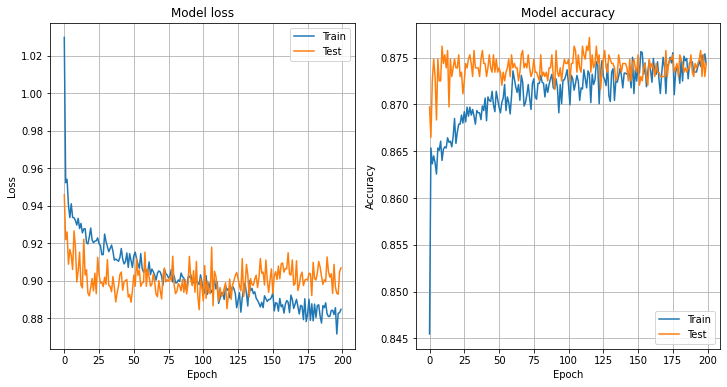

In [41]:
# Plot training & validation accuracy values
# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=[12,6])

ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_title('Model accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Test'])
ax2.grid('on')

# Plot training & validation loss values
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('Model loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Test'])
ax1.grid('on');

In [42]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# predict probabilities for test set
yhat_probs = lstm.predict(x_test, verbose=0)

# predict classes for test set
yhat_classes = lstm.predict_classes(x_test, verbose=0)

# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
 
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

# ROC AUC
auc = roc_auc_score(y_test, yhat_probs)
print('ROC AUC: %f' % auc)

# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

Accuracy: 0.874363
Precision: 0.863436
Recall: 0.449541
F1 score: 0.591252
ROC AUC: 0.834545
[[1690   31]
 [ 240  196]]


In [43]:
# serialize model to JSON
model_json = lstm.to_json()
with open("lstm.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
lstm.save_weights("lstm.h5")
print("Saved model to disk")

Saved model to disk
